# Temporal mismatch diagnostics

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd
import os
from glob import glob

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo

import matplotlib.transforms as mtransforms
crs = ccrs.PlateCarree()

import histlib.matchup as match
from  histlib.diagnosis import build_matchup_dataframe, synthetic_figure, path_csv, put_fig_letter, build_diagnostic
from histlib.cstes import labels, zarr_dir, matchup_dir, c0, U
U2=U**2
zarr_dir =zarr_dir +'_ok'

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


__________
___________
# Compute mean

In [24]:
comb_av_d = {'acc':'drifter_acc_x_25', 'cor':'drifter_coriolis_x_25', 'ggx':'aviso_drifter_ggx_adt', 'wd':'es_cstrio_z15_drifter_wd_x'}
comb_av_al = {'acc':'drifter_acc_x_25', 'cor':'drifter_coriolis_x_25', 'ggx':'aviso_alti_ggx_adt', 'wd':'es_cstrio_z15_drifter_wd_x'}
comb_alg = {'acc':'drifter_acc_x_25','cor':'drifter_coriolis_x_25','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}


dad = pd.read_csv(os.path.join(zarr_dir,'analysis_files', 'time_mean___'+'__'.join([comb_av_d[key] for key in comb_av_d])+'.csv')).set_index('timebin').to_xarray()
#daa = pd.read_csv(os.path.join(zarr_dir,'analysis_files', 'time_mean___'+'__'.join([comb_av_al[key] for key in comb_av_al])+'.csv')).set_index('timebin').to_xarray()
dl = pd.read_csv(os.path.join(zarr_dir,'analysis_files', 'time_mean___'+'__'.join([comb_alg[key] for key in comb_alg])+'.csv')).set_index('timebin').to_xarray()

def center_timebin(df) :
    dl = df.timebin.diff('timebin').mean()/3600
    df['timebin'] = df['timebin']/3600+dl/2
    return df

def prepared(ds) : 
    ds_ = center_timebin(ds).set_coords(['obs', 'nb_coloc_bin', 'alti___time_difference'])/U2
    ds_.nb_coloc_bin.attrs['long_name'] = 'Number of colocalizations per bin'
    ds_.timebin.attrs['long_name'] = 'Temporal colocalization mismatch $\Delta T$'
    ds_.timebin.attrs['units'] = 'h'
    return ds_
    
dad = prepared(dad)
#daa = prepared(daa)
dl = prepared(dl)

In [13]:
dl

<xarray.Dataset>
Dimensions:                 (timebin: 178)
Coordinates:
  * timebin                 (timebin) float64 0.002542 0.01921 ... 1.403 0.9025
    alti___time_difference  (timebin) float64 19.03 89.73 ... 3.268e+03
    obs                     (timebin) float64 5.528e+04 5.464e+04 ... 9.756e+04
    nb_coloc_bin            (timebin) int64 12318 7853 7857 8040 ... 3 2 2 2
Data variables: (12/40)
    B_acc                   (timebin) float64 0.8449 0.9154 ... 11.76 0.02444
    E_acc                   (timebin) float64 0.2222 0.1805 ... 7.733 0.07254
    E_cor                   (timebin) float64 0.6145 0.6706 ... -5.242 -0.04939
    B_cor                   (timebin) float64 3.339 3.14 3.158 ... 14.17 0.08684
    E_ggx                   (timebin) float64 0.7555 0.7893 ... 0.642 0.07857
    B_ggx                   (timebin) float64 2.717 2.585 ... -0.2303 -0.01634
    ...                      ...
    be__ACC                 (timebin) float64 0.02857 0.03943 ... nan nan
    be__COR                 (timebin) float64 0.1178 0.1286 0.1168 ... nan nan
    be__GGX                 (timebin) float64 0.1146 0.1275 0.1106 ... nan nan
    be__WD                  (timebin) float64 0.006034 0.007682 ... nan nan
    be__S                   (timebin) float64 0.04289 0.05671 ... nan nan
    be__sigma               (timebin) float64 0.2241 0.2422 0.2176 ... nan nan

__________
___________
# Distribution

(0.0, 0.5)

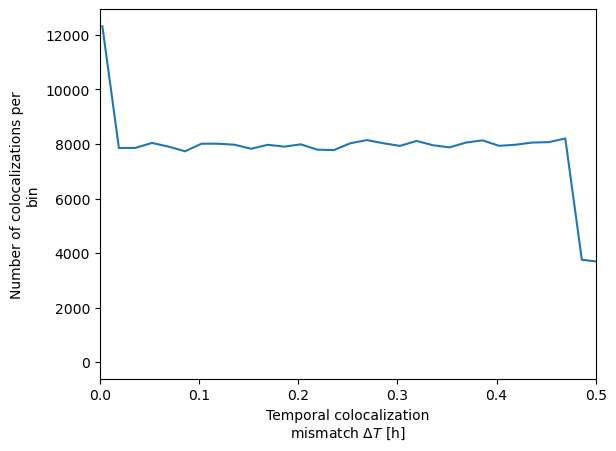

In [15]:
dl.nb_coloc_bin.plot()
plt.xlim(0, 0.5)

__________
___________
# Figures

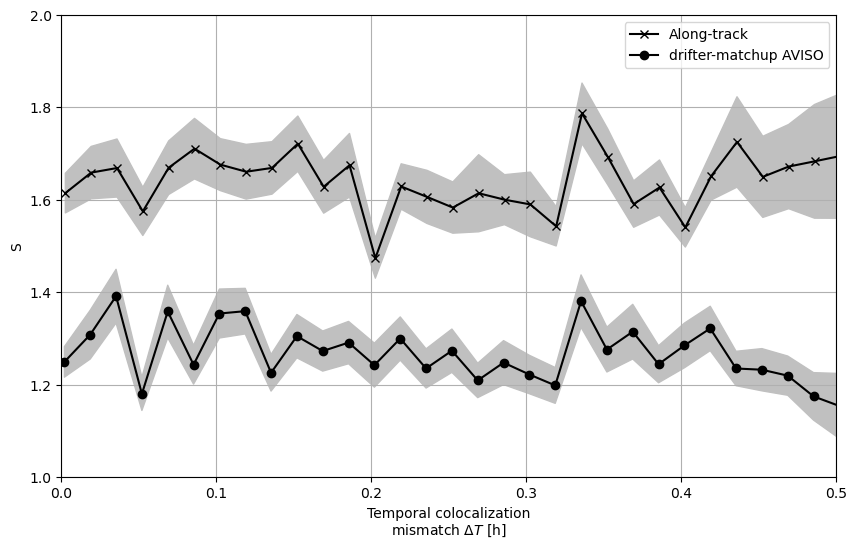

In [26]:
def plot_error(df, v, ax):
    ax.fill_between(df.timebin, df[v]-df['be__'+v], df[v]+df['be__'+v], color='silver')

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10,6))
dl.S.plot(marker = 'x', label= 'Along-track', c='k')
plot_error(dl, 'S', ax)
dad.S.plot(marker = 'o', label= 'drifter-matchup AVISO', c='k')
plot_error(dad, 'S', ax)
#daa.S.plot(marker = 's', label= 'altimeter-matchup AVISO', c='k')
#plot_error(daa, 'S', ax)





ax.set_xlim(0,0.5)
ax.set_ylim(1,2)
ax.set_xlabel('
ax.grid()
ax.legend()

In [34]:
def exp_decay(dx, dx_constant, amplitude, cst):
    return np.exp(-dx / dx_constant)*amplitude +cst

fit_cor_alg = dl.X_cor_ggx.curvefit("distbin", exp_decay)
fit_acc_alg = dl.X_acc_ggx.curvefit("distbin", exp_decay)
fit_cor_av = daa.X_cor_ggx.curvefit("distbin", exp_decay)
fit_acc_av = daa.X_acc_ggx.curvefit("distbin", exp_decay)
#fit_cor_wd_alti = cor_wd_alti.curvefit("distbin", exp_decay)

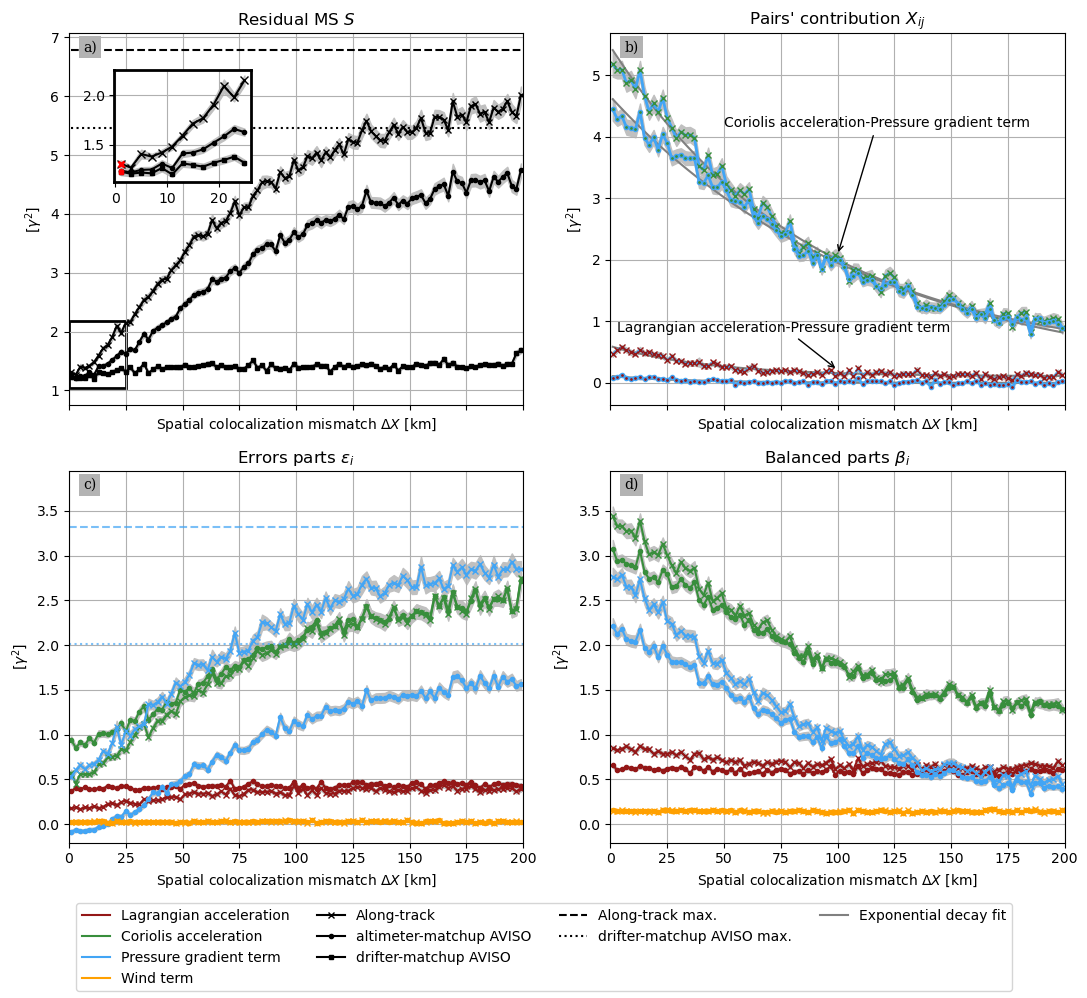

In [36]:
def plot_error(df, v, ax):
    ax.fill_between(df.distbin, df[v]-df['be__'+v], df[v]+df['be__'+v], color='silver')

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(11,10), frameon=False)
axs =axs.flatten()

# plot param 
m =3 #markersize
a=0.7
ins_ax_box = [0.1,0.60,0.3,0.3]#[x0,y0,xlen, ylen]
import matplotlib.patches as patches

ax =axs[0]
dl.S.plot(label='Along-track', ax=ax, c='k', marker='x', markeredgewidth = 1, markersize=m+1)
daa.S.plot(label='altimeter-matchup AVISO', ax=ax, c='k', marker='o', markersize=m)
dad.S.plot(label='drifter-matchup AVISO', ax=ax, c='k', marker='s', markersize=m,)
born_co.plot(ax=ax, color='k', ls = 'dashed')
born_av.plot(ax=ax,color='k', ls = ':')
plot_error(dl, 'S', ax)
plot_error(daa, 'S', ax)
plot_error(dad, 'S', ax)

ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r"$[\gamma^2]$")
ax.set_title(r'Residual MS $S$')
put_fig_letter(fig, ax, 'a')
handles0, labels0 = ax.get_legend_handles_labels()

#ZOOM
rect = patches.Rectangle((0, 1e-10/U2), 25, 1.1e-10/U2, linewidth=2, edgecolor='k', facecolor='none')
ax.add_patch(rect)
ins = ax.inset_axes(ins_ax_box)
dl.sel(distbin=slice(0, 25)).S.plot(label='Along-track', ax=ins, c='k', marker='x')
daa.sel(distbin=slice(0, 25)).S.plot(label='altimeter-matchup AVISO', ax=ins, c='k', marker='o', markersize=m)
dad.sel(distbin=slice(0, 25)).S.plot(label='drifter-matchup AVISO', ax=ins, c='k', marker='s', markersize=m,)
plot_error(dl.sel(distbin=slice(0, 25)), 'S', ins)
plot_error(daa.sel(distbin=slice(0, 25)), 'S', ins)
plot_error(dad.sel(distbin=slice(0, 25)), 'S', ins)
ins.plot(dl.S.isel(distbin=0).distbin, dl.S.isel(distbin=0), color='r', marker='x', markeredgewidth = 2,markersize=m+1)
ins.plot(daa.S.isel(distbin=0).distbin,daa.S.isel(distbin=0), color='r', marker='o', markersize=m)
ins.plot(dad.S.isel(distbin=0).distbin, dad.S.isel(distbin=0), color='r', marker='s', markersize=m,)

ins.grid()
ins.spines['bottom'].set_color('k')
ins.spines['top'].set_color('k')
ins.spines['left'].set_color('k')
ins.spines['right'].set_color('k')
ins.spines['bottom'].set_linewidth(2)
ins.spines['top'].set_linewidth(2)
ins.spines['left'].set_linewidth(2)
ins.spines['right'].set_linewidth(2)
ins.set_xlabel('')
ins.set_ylabel('')
#ins.set_ylim(1e-10, 2.1e-10)
#ax.annotate('',xy=(12.5,2.1e-10),xytext=(25,4.25e-10),arrowprops={'arrowstyle':'-', 'color':'k', 'linewidth':2})

ax =axs[1]

exp_decay(dl.distbin, *fit_cor_alg.curvefit_coefficients).plot(c='grey', label = 'Exponential decay fit', ax=ax)
exp_decay(dl.distbin, *fit_acc_alg.curvefit_coefficients).plot(c='grey', ax=ax)
exp_decay(daa.distbin, *fit_cor_av.curvefit_coefficients).plot( c='grey', ax=ax)
exp_decay(daa.distbin, *fit_acc_av.curvefit_coefficients).plot( c='grey', ax=ax)
dl.X_cor_ggx.plot(c = c0['ggx'], marker = 'x', markeredgewidth = 1, markeredgecolor=c0['cor'],markersize=m+1, lw=2, ax=ax)#,label= 'Coriolis acceleration - Pressure gradient estimated from along-track altimetry')
dl.X_acc_ggx.plot(c = c0['ggx'], marker = 'x', markeredgewidth = 1, markeredgecolor=c0['acc'],markersize=m+1, ax=ax)#, label= 'Lagrangian acceleration - Pressure gradient estimated from along-track altimetry')
daa.X_cor_ggx.plot(c = c0['ggx'], marker = 'o', markerfacecolor=c0['cor'], markersize=m, lw=2, ax=ax)#, label= 'Coriolis acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')
daa.X_acc_ggx.plot(c = c0['ggx'], marker = 'o', markerfacecolor=c0['acc'], markersize=m, lw=2, ax=ax)#, label= 'Lagrangian acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')
plot_error(dl, 'X_cor_ggx', ax)
plot_error(dl, 'X_acc_ggx', ax)
plot_error(daa, 'X_cor_ggx', ax)
plot_error(daa, 'X_acc_ggx', ax)

put_fig_letter(fig, ax, 'b')
handles_exp, labels_exp = ax.get_legend_handles_labels()


ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r"$[\gamma^2]$")
ax.set_title(r"Pairs' contribution $X_{ij}$")
handles1, labels1 = ax.get_legend_handles_labels()

ax.annotate('Coriolis acceleration-Pressure gradient term', xy=(100, 2e-10/U2), xytext=(50, 4e-10/U2),
            arrowprops=dict(arrowstyle="->"))
ax.annotate('Lagrangian acceleration-Pressure gradient term', xy=(100, 0.2e-10/U2), xytext=(3, 0.8e-10/U2),
            arrowprops=dict(arrowstyle="->"))
ax = axs[2]

for v in ['acc', 'cor', 'ggx', 'wd']:
    dl['E_'+v].plot(label='Along Track ' +v, color = c0[v], marker='x',markeredgewidth = 1,markersize=m+1, ax=ax)
    plot_error(dl, 'E_'+v, ax)
    daa['E_'+v].plot(label='drifter-matchup AVISO ' +v, color = c0[v], marker='o',markersize=m, ax=ax)
    plot_error(daa, 'E_'+v, ax)
    if v=='ggx' : 
        ax.axhline(dl['GGX'].mean(), color = c0[v],  ls='--', alpha=a)
        ax.axhline(daa['GGX'].mean(), color = c0[v],  ls=':', alpha=a)
#ax.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
ax.set_xlim(0,200)
ax.set_ylim(-0.2e-10/U2,3.8e-10/U2)
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r"$[\gamma^2]$")
ax.set_title(r'Errors parts $\epsilon_i$')
put_fig_letter(fig, ax, 'c')

ax=axs[3]

for v in ['acc', 'cor', 'ggx', 'wd']:
    dl['B_'+v].plot(label='Along Track ' +v, color = c0[v], marker='x',markeredgewidth = 1,markersize=m+1, ax=ax)
    plot_error(dl, 'B_'+v, ax)
    daa['B_'+v].plot(label=' drifter-matchup AVISO ' +v, color = c0[v], marker='o',markersize=m, ax=ax)
    plot_error(daa, 'B_'+v, ax)
    
#ax.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
ax.set_xlim(0,200)
ax.set_ylim(-0.2e-10/U2,3.8e-10/U2)
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r"$[\gamma^2]$")
ax.set_title(r'Balanced parts $\beta_i$')

put_fig_letter(fig, ax, 'd')


for ax in axs :
    ax.grid()
handles, labels = handles_+handles0+handles_dummy+handles__+2*handles_dummy+handles_exp+3*handles_dummy, labels_+labels0+labels_dummy+labels__+2*labels_dummy+labels_exp+3*labels_dummy
fig.legend(handles, labels, ncols=4,loc='lower center')
fig.tight_layout(rect=[0,0.09,1,1])#left, bottom, right, top (default is 0,0,1,1)

#fig.savefig('../images_all/dist_total.png',bbox_inches='tight',   dpi=300)


__________
___________
# Colocalizations errors estimation

In [40]:
# 25 km dataset 

In [67]:
# 25 km dataset

def global_stast(df):
    from histlib.cstes import U
    #Mean
    mean = df.mean().compute()
    nb_coloc = len(df)
    mean['nb_coloc'] = nb_coloc

    #Central limit theorem
    errors = (2*df.std()/np.sqrt(nb_coloc)).compute()

    df = pd.DataFrame([mean, errors],index=['value','errors']).transpose()/(U**2)

    df['percentage']= df.value/df.value.sigma *100
    df['percentage_erros']= df.percentage * np.sqrt((df.errors/df.value)**2 +(df.errors.sigma/df.value.sigma)**2)

    return df

DL, DT = 25e3, 30*60
comb_alg = {'acc':'drifter_acc_x_25','cor':'drifter_coriolis_x_25','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}
df_alg = dd.read_csv(path_csv(comb_alg, 'both', True, DL, DT)).repartition(npartitions=10)
dfalg = global_stast(df_alg)
dfalg

,value,errors,percentage,percentage_erros
obs,5.750261e+14,2.090045e+12,6.858768e+15,7.755345e+13
acc,3.906361e+02,4.228043e+02,4.659411e+03,5.043352e+03
cor,-2.229967e+02,8.182263e+02,-2.659850e+03,-9.759641e+03
drogue_status,1.039111e+10,0.000000e+00,1.239426e+11,1.327064e+09
ggx,1.970851e+03,7.609455e+02,2.350782e+04,9.079858e+03
wd,-1.304171e+02,1.715550e+02,-1.555583e+03,-2.046334e+03
alti___distance,1.326366e+14,2.974264e+11,1.582056e+15,1.730673e+13
alti___time_difference,9.049134e+12,2.209272e+10,1.079358e+14,1.185341e+12
lat,4.097575e+10,1.680418e+09,4.887485e+11,2.071548e+10
lon,-1.165983e+11,4.384160e+09,-1.390756e+12,-5.437201e+10


In [76]:
dl_ = dl.sel(distbin=slice(0,4)).mean()

In [77]:
vars = ['S', 'E_acc', 'E_cor', 'E_ggx', 'E_wd']
for v in vars :
    coloc_error = np.round(dfalg.loc[v].value - dl_[v].values,4)
    S_perc = np.round((dfalg.loc[v].value - dl_[v].values)/dfalg.loc['S'].value*100, 2)
    print(f" {v} : {coloc_error} so {S_perc}% of the residual MS" )

 S : 0.3511 so 21.43% of the residual MS
 E_acc : 0.0206 so 1.26% of the residual MS
 E_cor : 0.1404 so 8.57% of the residual MS
 E_ggx : 0.1941 so 11.85% of the residual MS
 E_wd : -0.004 so -0.24% of the residual MS
